In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 22})
import matplotlib as mpl
from matplotlib import cm # allows to do color map
from matplotlib.gridspec import GridSpec
import networkx as nx
import pandas as pd
from scipy.optimize import fsolve

# physical review E column width in inches
col_width = 3+3/8
plt.style.use("style.mplstyle") # closer to LaTeX

# random graph model
from HydrocarbonSimulationHelpers import *

In [2]:
# Summary data
global_data = pd.read_pickle('../../Data/processed_MD/GlobalData.pickle')
skeleton_data = pd.read_pickle('../../Data/processed_MD/SkeletonData.pickle')
# Summary data average between runs
Indices = sorted(list(set([i[:-2] for i in skeleton_data.index])))
Indices.remove('CH4_3300K')
global_data_avg = pd.DataFrame(columns=global_data.columns)
skeleton_data_avg = pd.DataFrame(columns=skeleton_data.columns)
def aux_f(x):
    if type(x) == str: return x[:len(x)//2]
    else: return x/2
for idx in Indices:
    if idx == 'CH4_3300K': 
        global_data_avg.loc[idx] = global_data.loc[idx+'_2']
        skeleton_data_avg.loc[idx] = skeleton_data.loc[idx+'_2']
    else:
        skeleton_data_avg.loc[idx] = (skeleton_data.loc[idx+'_1']+skeleton_data.loc[idx+'_2'])/2
        global_data_avg.loc[idx] = (global_data.loc[idx+'_1']+global_data.loc[idx+'_2']).apply(aux_f)

In [3]:
LoopData = pd.read_pickle('../../Data/Random Graphs/Loop_Counts.pickle')

# Sample loop related statistics from each model

In [10]:
RG_Loop_Dict = {'PoissonFit':[],
                'Conf_CountDist':[],'Conf_LengthDist':[],'Conf_Assort':[],
                'Loop_Assort':[],'Loop_Assort_GF':[],
                'Proposed_CountDist':[],'Proposed_LengthDist':[],'Proposed_Assort':[]}

P3_vec = global_data_avg['CDegDist'].apply(lambda x: x[3]/(x[3]+x[4]))

eCounter=0

for x,key in enumerate(Indices):
    print(key)
    # unpack
    Nc,Nh = global_data_avg['Nc'].loc[key],global_data_avg['Nh'].loc[key]
    hcr = Nh/Nc
    temp = global_data_avg['Temp'].loc[key]
    phh = (2*global_data_avg['Nhh']/(2*global_data_avg['Nhh']+global_data_avg['Nch'])).loc[key]
    p3 = P3_vec.loc[key]

    # loop distribution from MD
    LoopLenDist = skeleton_data_avg['LoopSizeDist'].loc[key]
    LoopLenDist/= sum(LoopLenDist[:26])
    CountDist = skeleton_data_avg['LoopCountDist'].loc[key]
    CountDist/= sum(CountDist[:31])
    Lam = CountDist@np.arange(len(CountDist))/Nc

    # data from fit
    p3_fit,phh_fit   = p3_from_fit(hcr,temp),phh_from_fit(hcr,temp)
    LamPhi_fit       = loop_from_fit(hcr,temp)                      
    Lam_fit          = sum(LamPhi_fit)
    LoopLenDist_fit = LamPhi_fit/Lam_fit
    
    # Obtain data
    Trials = 10000
    # model 1 - configuration model
    Conf_Samples = []
    Conf_Counts  = np.zeros(Trials,dtype=int)
    Assort_Samples = np.zeros(Trials)
    for i in range(Trials):
        if i % 1000 == 0:
            print('{:4.1f}'.format(i/Trials/3*100)+'%\r',end='')
        HCN = randHCnet_from_params(Nc,Nh,phh,p3)
        MCB = HCN.MCB()                             # minimum cycle basis
        Conf_Counts[i] = len(MCB)                   # circuit rank
        Conf_Samples.extend([len(C) for C in MCB])
        Assort_Samples[i] = HCN.assort_C()          # degree assortativity coeff
    RG_Loop_Dict['Conf_Assort'].append(np.mean(Assort_Samples))

    # model 2 - Disjoint Loop
    Assort_Samples = np.zeros(Trials)
    for i in range(Trials):
        if i % 100 == 0:
            print('{:4.1f}'.format(i/Trials/3*100+100/3)+'%\r',end='')
        # sample
        while True:
            HCN = randHCnet_from_params(Nc,Nh,phh,p3,Lam,LoopLenDist)
            if not HCN.eFlag: 
                break
            eCounter+=1 # poor sampled loop lengths...
        Assort_Samples[i] = HCN.assort_C()
    RG_Loop_Dict['Loop_Assort'].append(np.mean(Assort_Samples))
    print('Model 2 Assort:','{:7.4f}'.format(np.mean(Assort_Samples)),u"\u00B1",'{:5.4f}'.format(np.std(Assort_Samples)/np.sqrt(Trials)))
    X = randHCnet_GF(hcr,phh,p3,Lam,LoopLenDist)
    RG_Loop_Dict['Loop_Assort_GF'].append(X.assortivity_coefficient())

    # proposed model
    Proposed_Samples = []
    Proposed_Counts  = np.zeros(Trials,dtype=int)
    Assort_Samples = np.zeros(Trials)
    for i in range(Trials):
        if i % 100 == 0:
            print('{:4.1f}'.format(i/Trials/3*100+2*100/3)+'%\r',end='')
        # sample
        while True:
            HCN = randHCnet_from_params(Nc,Nh,phh_fit,p3_fit,Lam_fit,LoopLenDist_fit)
            if not HCN.eFlag: 
                break
            eCounter+=1 # poor sampled loop lengths...
        HCN.assort_correct(round(2*Nc*Lam_fit+500))
        # for j in range(steps):
        MCB = HCN.MCB()
        Proposed_Counts[i] = len(MCB)
        Proposed_Samples.extend([len(C) for C in MCB])
        Assort_Samples[i] = HCN.assort_C()
    RG_Loop_Dict['Proposed_Assort'].append(np.mean(Assort_Samples))
    print('Proposed Model Assort:','{:7.4f}'.format(np.mean(Assort_Samples)),u"\u00B1",'{:5.4f}'.format(np.std(Assort_Samples)/np.sqrt(Trials)))
        

    # length data
    Conf_pmf = np.zeros_like(LoopLenDist)
    Proposed_pmf = np.zeros_like(LoopLenDist)
    for x in Conf_Samples: Conf_pmf[min(x,26)]+=1
    Conf_pmf/= sum(Conf_pmf[:26])
    for x in Proposed_Samples: Proposed_pmf[min(x,26)]+=1
    Proposed_pmf/= sum(Proposed_pmf[:26])
    # save data for lengths
    RG_Loop_Dict['Conf_LengthDist'].append(Conf_pmf)
    RG_Loop_Dict['Proposed_LengthDist'].append(Proposed_pmf)

    # Count data
    Pois_pmf = np.zeros_like(CountDist)
    Pois_pmf[0] = np.exp(-Lam*Nc)
    for i in range(1,len(Pois_pmf)):
        Pois_pmf[i] = Pois_pmf[i-1]*Lam*Nc/i
    ConfCount_pmf = np.zeros_like(CountDist)
    for L in Conf_Counts: ConfCount_pmf[min(L,31)]+=1
    ConfCount_pmf/= sum(ConfCount_pmf[:31])
    ProposedCount_pmf = np.zeros_like(CountDist)
    for L in Proposed_Counts: ProposedCount_pmf[min(L,31)]+=1
    ProposedCount_pmf/= sum(ProposedCount_pmf[:31])
    # save it
    RG_Loop_Dict['PoissonFit'].append(Pois_pmf)
    RG_Loop_Dict['Conf_CountDist'].append(ConfCount_pmf)
    RG_Loop_Dict['Proposed_CountDist'].append(ProposedCount_pmf)

# save
LoopData = pd.DataFrame(RG_Loop_Dict,index=global_data_avg.index)
LoopData.to_pickle('../../Data/Random Graphs/Loop_Counts.pickle')

C2H6_3300K
Model 2 Assort:  0.0200 ± 0.0009
Proposed Model Assort:  0.0004 ± 0.0009
C2H6_4000K
Model 2 Assort:  0.0463 ± 0.0009
Proposed Model Assort:  0.0035 ± 0.0008
C2H6_4000K_1280at
Model 2 Assort:  0.0421 ± 0.0008
Proposed Model Assort:  0.0028 ± 0.0007
C4H10_3200K
Model 2 Assort:  0.0501 ± 0.0008
Proposed Model Assort:  0.0067 ± 0.0007
C4H10_3300K
Model 2 Assort:  0.0447 ± 0.0008
Proposed Model Assort:  0.0061 ± 0.0007
C4H10_3400K
Model 2 Assort:  0.0727 ± 0.0008
Proposed Model Assort:  0.0063 ± 0.0007
C4H10_3500K
Model 2 Assort:  0.0794 ± 0.0008
Proposed Model Assort:  0.0063 ± 0.0007
C4H10_3600K
Model 2 Assort:  0.0817 ± 0.0008
Proposed Model Assort:  0.0060 ± 0.0007
C4H10_3600K_1120at
Model 2 Assort:  0.0809 ± 0.0007
Proposed Model Assort:  0.0053 ± 0.0006
C4H10_4000K
Model 2 Assort:  0.0615 ± 0.0008
Proposed Model Assort:  0.0067 ± 0.0007
C4H10_4500K
Model 2 Assort:  0.0680 ± 0.0008
Proposed Model Assort:  0.0075 ± 0.0007
C4H10_5000K
Model 2 Assort:  0.0654 ± 0.0008
Proposed 

c:\Users\HP\miniforge3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


Model 2 Assort:     nan ±   nan
Proposed Model Assort: -0.0097 ± 0.0019
CH4_3600K
Model 2 Assort: -0.0273 ± 0.0016
Proposed Model Assort: -0.0034 ± 0.0017
CH4_4500K
Model 2 Assort:  0.0171 ± 0.0013
Proposed Model Assort:  0.0029 ± 0.0013
mix_3500K
Model 2 Assort:  0.0159 ± 0.0009
Proposed Model Assort:  0.0013 ± 0.0009


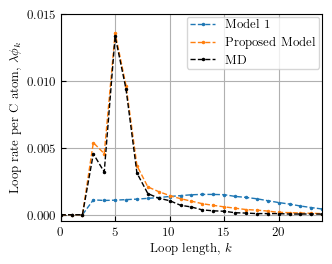

In [142]:
HCR_vec  = global_data_avg['Nh']/global_data_avg['Nc']
Temp_vec = global_data_avg['Temp']

plt.figure(figsize=(col_width,.8*col_width))

def mean_func(x):
    return x @ np.arange(len(x))

key   = 'C8H18_4000K_1040at'
label = r'${\rm C}_8{\rm H}_{18},\ 4000{\rm K},\ N_{\rm C}=320$'

Nc = global_data_avg.loc[key,'Nc']
plt.plot(LoopData.loc[key,'Conf_LengthDist'][:25] * mean_func(LoopData.loc[key,'Conf_CountDist'][:25])/Nc,'.--',\
            markersize=3,lw=1)
plt.plot(LoopData.loc[key,'Proposed_LengthDist'][:25] * mean_func(LoopData.loc[key,'Proposed_CountDist'][:25])/Nc,\
        '.--',markersize=3,lw=1)
plt.plot(skeleton_data_avg.loc[key,'LoopSizeDist'][:25] * mean_func(skeleton_data_avg.loc[key,'LoopCountDist'][:25])/Nc,\
        'k.--',markersize=3,lw=1)
plt.xlim([0,24])
plt.xlabel(r'Loop length, $k$')
plt.ylim([-5e-4,1.5e-2])
plt.yticks([0,0.005,0.01,0.015])
plt.ylabel(r'Loop rate per C atom, $\lambda \phi_k$')
plt.grid()

plt.legend(['Model 1','Proposed Model','MD'],borderaxespad=.25,borderpad=0.25,loc='upper right')

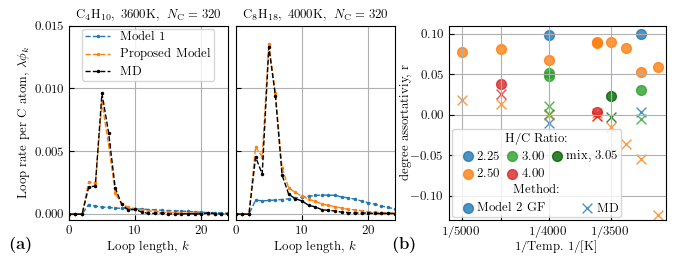

In [138]:
HCR_vec  = global_data_avg['Nh']/global_data_avg['Nc']
Temp_vec = global_data_avg['Temp']

fig = plt.figure(figsize=(2*col_width,4/5*col_width))
gs = GridSpec(1, 2, figure=fig,width_ratios=[.6,.4])
gs_0 = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0],wspace=.05)

ax = []

def mean_func(x):
    return x @ np.arange(len(x))

for i, item in enumerate([('C4H10_3600K_1120at',r'${\rm C}_4{\rm H}_{10},\ 3600{\rm K},\ N_{\rm C}=320$'),
                          ('C8H18_4000K_1040at',r'${\rm C}_8{\rm H}_{18},\ 4000{\rm K},\ N_{\rm C}=320$')]):
    key,label=item
    ax.append(fig.add_subplot(gs_0[0,i]))
    Nc = global_data_avg.loc[key,'Nc']
    ax[i].plot(LoopData.loc[key,'Conf_LengthDist'][:25] * mean_func(LoopData.loc[key,'Conf_CountDist'][:25])/Nc,'.--',\
               markersize=3,lw=1)
    ax[i].plot(LoopData.loc[key,'Proposed_LengthDist'][:25] * mean_func(LoopData.loc[key,'Proposed_CountDist'][:25])/Nc,\
            '.--',markersize=3,lw=1)
    ax[i].plot(skeleton_data_avg.loc[key,'LoopSizeDist'][:25] * mean_func(skeleton_data_avg.loc[key,'LoopCountDist'][:25])/Nc,\
            'k.--',markersize=3,lw=1)
    ax[i].set_xlim([0,24])
    ax[i].set_xlabel(r'Loop length, $k$')
    ax[i].set_ylim([-5e-4,1.5e-2])
    ax[i].set_yticks([0,0.005,0.01,0.015])
    if i == 0: 
        ax[i].set_ylabel(r'Loop rate per C atom, $\lambda \phi_k$')
    else: 
        ax[i].set_yticklabels([])
    ax[i].grid()
    ax[i].set_title(label,fontsize=9,pad=5)
    if i == 0: ax[i].legend(['Model 1','Proposed Model','MD'],borderaxespad=.25,borderpad=0.25,loc='upper center')


ax_assort = fig.add_subplot(gs[1])

msize = 50
alph=.8
width=1

cmin,cmax=4,2.25
colors = HCR_vec.apply( lambda t: cm.jet((t - cmin)/(cmax-cmin)) )
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)

h_vecMD    = [i for i in range(5)]
h_vecM2RGS = [i for i in range(5)]
h_vecM2GF  = [i for i in range(5)]
h_vecProp  = [i for i in range(5)]

for i,hcr in enumerate([2.25,2.5,3,3.05,4]):
    idx = HCR_vec==hcr

    if hcr==3.05: color='darkgreen'
    elif hcr==4: color='C3'
    else: color = 'C' + str(i)

    # Model 2
    # with GF
    h_vecM2GF[i] = ax_assort.scatter(1/Temp_vec.loc[idx],LoopData.loc[idx,'Loop_Assort_GF'],\
                                    marker='o',c=color,s=msize,lw=width,alpha=alph)
    # MD
    h_vecMD[i] = ax_assort.scatter(1/Temp_vec.loc[idx],skeleton_data_avg.loc[idx,'r'],\
                                   marker='x',c=color,s=msize,lw=width,alpha=alph)
b = ax_assort.scatter([],[],marker='none')
h_vec = [b]
h_vec.extend(h_vecProp)
h_vec.extend([b,h_vecM2RGS[0],h_vecMD[0]])
aux = ' '*4

# ax_assort.add_artist(legend_1)
h_vecM2GF.append(h_vecM2GF[-2])
h_vecM2GF.pop(-3)
aux = '\\vspace{10pt}'
legend_1 = ax_assort.legend(handles=[h_vecM2GF[0],h_vecM2GF[1],b,b,h_vecM2GF[2],h_vecM2GF[3],b,b,h_vecM2GF[4],b,b,b],
                            labels =['2.25','2.50','','','3.00','4.00','','','mix, 3.05','','',''],ncol=3,
                            title = 'H/C Ratio:',
                            columnspacing=0,handletextpad=-0.25,borderpad=0.25,borderaxespad=0.25)
ax_assort.add_artist(legend_1)
ax_assort.legend(handles=[h_vecM2GF[0],h_vecMD[0]], labels =['Model 2 GF', 'MD'],ncol=2,
                 title = 'Method:',
                 columnspacing=2.35,handletextpad=-0.25,borderpad=0.25,borderaxespad=0.25,frameon=False)
# ax_assort.legend(['Model 2 RGS / GF','Proposed Model RGS','MD'],loc='lower left')
ax_assort.set_ylim([-.145,.125])
ax_assort.set_ylabel('degree assortativiy, r',labelpad=1/2)
ax_assort.set_xlabel('1/Temp. 1/[K]',labelpad=2)
ax_assort.set_xticks(ticks=[1/3000,1/3500,1/4000,1/4500,1/5000],labels=["1/3000","1/3500","1/4000","1/4500"*0,"1/5000"])#,rotation=20)
ax_assort.set_xlim([1/5200,1/3150])
ax_assort.set_ylim([-.13,.11])
ax_assort.grid()
plt.tight_layout()
gs.update(wspace=.2)
ax_assort.text(-1/16500,-.165,'\\textbf{(a)}',fontsize=12)
ax_assort.text(1/6250,-.165,'\\textbf{(b)}',fontsize=12)

plt.savefig('../../Figures/Loops/LoopAssort.pdf')

In [8]:
# some time tests -> for a sample graph C4H10 4000K Nc=256
%timeit HCN.assort_correct(round(2*Nc*Lam_fit+500)) # longest thing
%timeit HCN.MCB()                                   # not so bad with new optimization
%timeit nx.minimum_cycle_basis(HCN.Gc())            # worse for comparison
%timeit HCN.assort_C()                              # networkx degree assortativity

24.6 ms ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.85 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
33.6 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.81 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# do we care about these?
mean = lambda x: x@np.arange(len(x)) # x1 + 2x2 + ...  
for key in LoopData.index:
    Nc = global_data_avg['Nc'].loc[key]
    # Loop Rates
    plt.subplots(figsize=(8,6))
    plt.plot(skeleton_data_avg['LoopSizeDist'].loc[key] *
             skeleton_data_avg['LoopCountDist'].apply(mean).loc[key] / Nc,'k.-')
    plt.plot(LoopData['Conf_LengthDist'].loc[key] * 
             LoopData['Conf_CountDist'].apply(mean).loc[key] / Nc,'C0.-')
    plt.plot(LoopData['rewire_LengthDist'].loc[key] * 
             LoopData['rewire_CountDist'].apply(mean).loc[key] / Nc,'C1.-')
    plt.legend(['MD','Model 1','Model 3'])
    plt.xlim([0,25])
    plt.xlabel('Loop Length, k')
    plt.ylabel('Rate per C atom, '+r'$\lambda\phi_k$')
    plt.tight_layout()
    # plt.show()
    plt.savefig('../../Figures/Loops/'+key+'_LoopRates.pdf')
    plt.close()

    
    # Loop length distribution
    plt.subplots(figsize=(8,6))
    plt.plot(skeleton_data_avg['LoopSizeDist'].loc[key],'k.-')
    plt.plot(LoopData['Conf_LengthDist'].loc[key],'C0.-')
    plt.plot(LoopData['rewire_LengthDist'].loc[key],'C1.-')
    plt.legend(['MD','Model 1','Model 3'])
    plt.xlim([0,25])
    plt.xlabel('Loop Length, k')
    plt.ylabel('probability '+r'$\phi_k$')
    plt.tight_layout()
    # plt.show()
    plt.savefig('../../Figures/Loops/'+key+'_LoopLengths.pdf')
    plt.close()

    # Loop Count distributions - roughly Poisson
    plt.subplots(figsize=(8,6))
    plt.plot(skeleton_data_avg['LoopCountDist'].loc[key],'k.')
    plt.plot(LoopData['PoissonFit'].loc[key],'C0.-')
    plt.plot(LoopData['Conf_CountDist'].loc[key],'C2.--')
    plt.plot(LoopData['rewire_CountDist'].loc[key],'C1.--')
    kmax = np.where((LoopData['rewire_CountDist'].loc[key]<1e-3)*(np.arange(len(LoopData['rewire_CountDist'].loc[key]))>10))[0][0]+3
    plt.xlim([0,kmax])
    plt.xlabel('# of independent loops')
    plt.ylabel('Probability')
    plt.legend(['MD','Poisson Approx.','Model 1','Model 3'],loc='upper right')
    plt.tight_layout()
    # plt.show()
    plt.savefig('../../Figures/Loops/'+key+'_LoopCounts.pdf')
    plt.close()